In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
import uproot as ur
import awkward as ak
import time as t
import copy
print(ak.__version__)

1.7.0


In [2]:
cell_meta = {
    'EMB1': {
        'cell_size_phi': 0.098,
        'cell_size_eta': 0.003125,
        'len_phi': 4,
        'len_eta': 128
    },
    'EMB2': {
        'cell_size_phi': 0.0245,
        'cell_size_eta': 0.025,
        'len_phi': 16,
        'len_eta': 16
    },
    'EMB3': {
        'cell_size_phi': 0.0245,
        'cell_size_eta': 0.05,
        'len_phi': 16,
        'len_eta': 8
    },
    'TileBar0': {
        'cell_size_phi': 0.1,
        'cell_size_eta': 0.1,
        'len_phi': 4,
        'len_eta': 4
    },
    'TileBar1': {
        'cell_size_phi': 0.1,
        'cell_size_eta': 0.1,
        'len_phi': 4,
        'len_eta': 4
    },
    'TileBar2': {
        'cell_size_phi': 0.1,
        'cell_size_eta': 0.2,
        'len_phi': 4,
        'len_eta': 2
    },
}

# note since TileBar2 does not fit nicely in eta granularity to <.7, we use up to .8
cell_granularity = {
    'EMB1': {
        'cell_size_phi': 0.098,
        'cell_size_eta': 0.003125,
        'nPhi': 32,
        'nEta': 448
    },
    'EMB2': {
        'cell_size_phi': 0.0245,
        'cell_size_eta': 0.025,
        'nPhi': 128,
        'nEta': 56
    },
    'EMB3': {
        'cell_size_phi': 0.0245,
        'cell_size_eta': 0.05,
        'nPhi': 128,
        'nEta': 28
    },
    'TileBar0': {
        'cell_size_phi': 0.1,
        'cell_size_eta': 0.1,
        'nPhi': 32,
        'nEta': 14
    },
    'TileBar1': {
        'cell_size_phi': 0.1,
        'cell_size_eta': 0.1,
        'nPhi': 32,
        'nEta': 14
    },
    'TileBar2': {
        'cell_size_phi': 0.1,
        'cell_size_eta': 0.2,
        'nPhi': 32,
        'nEta': 8
    }, 
}

In [3]:
def ak_to_np(_ak_arr):
    ''' Takes a nested array where some of the arrays are empty and returns
    a 1-D array with zeros where there are empty arrays. '''
    _np_arr = np.zeros(len(_ak_arr))
    for i in range(len(_ak_arr)):
        if _ak_arr[i].size > 0:
            _np_arr[i] = _ak_arr[i][0]
    return _np_arr

def empty_to_flag(_rawArr, _flag):
    ''' Takes a nested array where some of the arrays are empty and returns
    a 1-D array with _flag where there are empty arrays. '''
    retArr = np.empty(len(_rawArr))
    for i in range(len(_rawArr)):
        if _rawArr[i].size > 0:
            retArr[i] = _rawArr[i][0]
        else:
            retArr[i] = _flag
    return retArr

def DeltaR(_coord1, _coord2):
    _eta1,_phi1 = _coord1
    _eta2, _phi2 = _coord2
    return np.sqrt((_eta1-_eta2)**2 + (_phi1-_phi2)**2)

def find_unique(_arr):
    ''' finds all the unique elements in a 1-D array '''
    _unique = []
    for x in _arr:
        if not np.isin(x, _unique):
            _unique.append(x)
    return np.array(_unique)

def concat_array_list(_list):
    if _list:
        _N = len(_list)
        _n = len(_list[0])
        ret_arr = np.empty((_N,_n))
        for i in range(_N):
            ret_arr[i,:] = _list[i]
    else:
        ret_arr = np.array([])
    return ret_arr

def track_coords(_idx):
    ''' Returns a list of numpy arrays which contain the track information in the order of EMB1->TileBar2 '''
    
    _num_tracks = nTrack[_idx]
    
    # populate list of numpy arrays with track information in a block 
    _track_list = []
    for i in range(_num_tracks):
        
        _coords = np.empty((6,2))

        _coords[0,0] = ak_trackEta_EMB1[_idx]["trackEta_EMB1"][i]
        _coords[0,1] = ak_trackPhi_EMB1[_idx]["trackPhi_EMB1"][i]
        _coords[1,0] = ak_trackEta_EMB2[_idx]["trackEta_EMB2"][i]
        _coords[1,1] = ak_trackPhi_EMB2[_idx]["trackPhi_EMB2"][i]
        _coords[2,0] = ak_trackEta_EMB3[_idx]["trackEta_EMB3"][i]
        _coords[2,1] = ak_trackPhi_EMB3[_idx]["trackPhi_EMB3"][i]
    
        _coords[3,0] = ak_trackEta_TileBar0[_idx]["trackEta_TileBar0"][i]
        _coords[3,1] = ak_trackPhi_TileBar0[_idx]["trackPhi_TileBar0"][i]
        _coords[4,0] = ak_trackEta_TileBar1[_idx]["trackEta_TileBar1"][i]
        _coords[4,1] = ak_trackPhi_TileBar1[_idx]["trackPhi_TileBar1"][i]
        _coords[5,0] = ak_trackEta_TileBar2[_idx]["trackEta_TileBar2"][i]
        _coords[5,1] = ak_trackPhi_TileBar2[_idx]["trackPhi_TileBar2"][i]
        
        _track_list.append(_coords)
    
    return _track_list

def track_av(_arr):
    ''' Expects a (6,2) np array for the barrel layers in order of eta, phi '''
    _av_Eta = np.sum(_arr[:,0])/6
    _av_Phi = np.sum(_arr[:,1])/6
    return np.array([_av_Eta, _av_Phi])

def find_sampling_events_vectorized(_event_dict, _geo_dict, _filter):
    ''' Inputs:
    _ak_cluster_cell_ID: awkward array with nested arrays of all the cell geometry IDs
    _cellGeoID: list of the cell IDs to find the index from, expects numpy format
    _cellGeoSampling: same as _cellGeoID but the sampling layer
    _filter: the numbered index of calorimetry layers
    Returns:
    an array of event indices with clusters containing barrel events
    '''

    # list of event indices with one or more clusters in EMB1-3 or TileBar0-2
    _barrel_events = []
    
    _ak_cluster_cell_ID = _event_dict['cluster_cell_ID']
    _cell_geo_ID = _geo_dict['cell_geo_ID']
    _geo_sampling = _geo_dict['cell_geo_sampling']
    
    for _evt_idx in range(len(_ak_cluster_cell_ID)):
        _cluster_cell_IDs = _ak_cluster_cell_ID[_evt_idx]

        for j in range(len(_cluster_cell_IDs)):
            _geo_idx = find_index_1D(_cluster_cell_IDs[j].to_numpy(), _cell_geo_ID)
            _sampling_layers = _geo_sampling[_geo_idx]
            
            # if any of these are in the filter
            if np.any(np.isin(_filter, _sampling_layers)):
                _barrel_events.append(_evt_idx)
                # break to next event
                break

    return np.array(_barrel_events)

#### Working with function to get the x,y,z coordinates from eta phi rPerp

#### x,y,z cell position
cell_x = rperp*np.cos(cell_phi)
cell_y = rperp*np.sin(cell_phi)
cell_z = rperp/np.tan(cell_theta)

cell_positions = np.column_stack([cell_x,cell_y,cell_z])

In [4]:
path_prefix = '/Work/EPE/ML4pi/'

In [5]:
import sys
sys.path.append(path_prefix)

In [6]:
events = path_prefix + '/atlas_images/pipm/'

In [7]:
event_502 = ur.open(events+'user.angerami.24559744.OutputStream._000502.root')
my_event=event_502
event_502.keys()

['EventTree;1', 'CellGeo;1']

## Event Tree

In [8]:
event_tree = my_event["EventTree"]
event_tree.show(name_width=42,
                interpretation_width=60)

name                                       | typename                 | interpretation                                              
-------------------------------------------+--------------------------+-------------------------------------------------------------
runNumber                                  | int32_t                  | AsDtype('>i4')
eventNumber                                | int64_t                  | AsDtype('>i8')
lumiBlock                                  | int32_t                  | AsDtype('>i4')
coreFlags                                  | uint32_t                 | AsDtype('>u4')
mcEventNumber                              | int32_t                  | AsDtype('>i4')
mcChannelNumber                            | int32_t                  | AsDtype('>i4')
mcEventWeight                              | float                    | AsDtype('>f4')
nTruthPart                                 | int32_t                  | AsDtype('>i4')
G4PreCalo_n_EM                        

## Cell Geometry Tree

In [9]:
CellGeo_tree = my_event["CellGeo"]
CellGeo_tree.show(interpretation_width=60)

name                 | typename                 | interpretation                                              
---------------------+--------------------------+-------------------------------------------------------------
cell_geo_ID          | std::vector<uint64_t>    | AsJagged(AsDtype('>u8'), header_bytes=10)
cell_geo_sampling    | std::vector<uint16_t>    | AsJagged(AsDtype('>u2'), header_bytes=10)
cell_geo_eta         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_phi         | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_rPerp       | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_deta        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_dphi        | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_volume      | std::vector<float>       | AsJagged(AsDtype('>f4'), header_bytes=10)
cell_geo_sigma       | std::vector<float> 

## Cluster ID and Geometry Information

In [10]:
# Geometry information
cell_geo_ID = CellGeo_tree.arrays(filter_name='cell_geo_ID')[0]["cell_geo_ID"].to_numpy()
cell_geo_eta = CellGeo_tree.arrays(filter_name='cell_geo_eta')[0]["cell_geo_eta"].to_numpy()
cell_geo_phi = CellGeo_tree.arrays(filter_name='cell_geo_phi')[0]["cell_geo_phi"].to_numpy()
cell_geo_rPerp = CellGeo_tree.arrays(filter_name='cell_geo_rPerp')[0]["cell_geo_rPerp"].to_numpy()
cell_geo_deta = CellGeo_tree.arrays(filter_name='cell_geo_deta')[0]["cell_geo_deta"].to_numpy()
cell_geo_dphi = CellGeo_tree.arrays(filter_name='cell_geo_dphi')[0]["cell_geo_dphi"].to_numpy()
cell_geo_sampling = CellGeo_tree.arrays(filter_name='cell_geo_sampling')[0]["cell_geo_sampling"].to_numpy()

''' Notes: -because the geometry information is stored differently in cell_geo we can simply extract the np
arrays by referencing the zeroth element of the awkward arrays. This is because the cell geos are a single
nested ak array (it seems so far anyways) '''

# Event information
ak_cluster_nCells = event_tree.arrays(filter_name="cluster_nCells")
ak_cluster_cell_ID = event_tree.arrays(filter_name="cluster_cell_ID")
ak_cluster_cell_E = event_tree.arrays(filter_name="cluster_cell_E")
nCluster = event_tree.arrays(library='np')["nCluster"]
eventNumber = event_tree.arrays(library='np')["eventNumber"]
nTrack = event_tree.arrays(library='np')["nTrack"]
ak_cluster_Eta = event_tree.arrays(filter_name="cluster_Eta")
ak_cluster_Phi = event_tree.arrays(filter_name="cluster_Phi")
ak_cluster_CENTER_MAG = event_tree.arrays(filter_name="cluster_Eta")
ak_cluster_CENTER_LAMBDA = event_tree.arrays(filter_name="cluster_Phi")

#### Load Track Information

In [11]:
ak_trackEta_EMB1 = event_tree.arrays(filter_name="trackEta_EMB1")
ak_trackEta_EMB2 = event_tree.arrays(filter_name="trackEta_EMB2")
ak_trackEta_EMB3 = event_tree.arrays(filter_name="trackEta_EMB3")
ak_trackPhi_EMB1 = event_tree.arrays(filter_name="trackPhi_EMB1")
ak_trackPhi_EMB2 = event_tree.arrays(filter_name="trackPhi_EMB2")
ak_trackPhi_EMB3 = event_tree.arrays(filter_name="trackPhi_EMB3")

ak_trackEta_TileBar0 = event_tree.arrays(filter_name="trackEta_TileBar0")
ak_trackEta_TileBar1 = event_tree.arrays(filter_name="trackEta_TileBar1")
ak_trackEta_TileBar2 = event_tree.arrays(filter_name="trackEta_TileBar2")
ak_trackPhi_TileBar0 = event_tree.arrays(filter_name="trackPhi_TileBar0")
ak_trackPhi_TileBar1 = event_tree.arrays(filter_name="trackPhi_TileBar1")
ak_trackPhi_TileBar2 = event_tree.arrays(filter_name="trackPhi_TileBar2")

ak_trackPt = event_tree.arrays(filter_name='trackPt')['trackPt']
nTrack = event_tree.arrays(filter_name='nTrack')['nTrack'].to_numpy()
ak_trackNumberOfPixelHits = event_tree.arrays(filter_name='trackNumberOfPixelHits')['trackNumberOfPixelHits']
ak_trackNumberOfSCTHits = event_tree["trackNumberOfSCTHits"].arrays(library="np")['trackNumberOfSCTHits']
ak_trackChiSquared = event_tree.arrays(filter_name='trackChiSquared')['trackChiSquared']
ak_trackNumberDOF = event_tree.arrays(filter_name='trackNumberDOF')['trackNumberDOF']
ak_trackD0 = event_tree.arrays(filter_name='trackD0')['trackD0']
ak_trackZ0 = event_tree.arrays(filter_name='trackZ0')['trackZ0']

# Filtering Events
The purpose of this is to create a list of selected events which index awkward array events which we are interested in

In [12]:
## TO DO: - Use track information and a loop to find an event which has track eta near zero...

#### Find Barrel Events

In [13]:
N_events = len(ak_cluster_nCells)
event_search = range(N_events)

# Create list for sampling layers per event!
sample_layers = []
# list of event indices with one or more clusters in EMB1-3 or TileBar0-2
barrel_events = []
calo_layer_filter = np.array([1,2,3,12,13,14])

for _evt_idx in event_search:
    cluster_cell_ID = ak_cluster_cell_ID["cluster_cell_ID"][_evt_idx]
    
    # create unique list of sampling layers for every cluster
    _event_layers = []

    # print('Working on event '+str(_evt_idx))
    for j in range(len(cluster_cell_ID)):
        ''' loop through each cluster of the event '''

        for l in range(len(cluster_cell_ID[j])):
            ''' loop through the cluster elements searching for new layer numbers'''
            # grab the first cell_geo_ID
            _cell_geo_tag = cluster_cell_ID[j][l]
        
            # find the index of the cell_geo_ID, use [0][0] becuase of np.where return
            _cell_geo_idx = np.where(cell_geo_ID == _cell_geo_tag)[0][0]

            # find the sampling layer based on the index
            this_layer = cell_geo_sampling[_cell_geo_idx]

            if not np.isin(this_layer, _event_layers):
                _event_layers.append(this_layer)      
            
        # Append the layer to the list, definitely want sample layers to be from each event
        sample_layers.extend(_event_layers)
        
    # add event to list if one is in the barrel layer
    if np.any(np.isin(_event_layers, calo_layer_filter)):
        barrel_events.append(_evt_idx)
        
sample_layers = np.array(sample_layers)
barrel_events = np.array(barrel_events)

In [14]:
print(barrel_events[0:20])

[ 0  2  3  6  7 11 14 20 22 26 28 29 30 31 32 33 37 38 42 44]


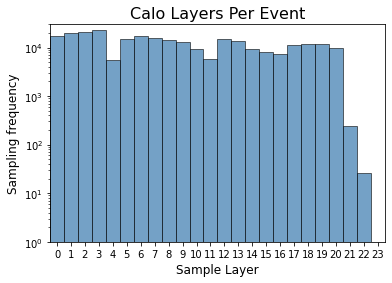

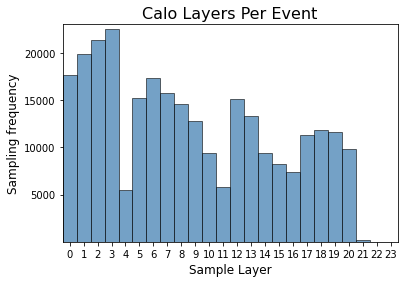

' Note: what this histogram is showing is the *unique* calorimeter layer activation per event'

In [15]:
bin_list = np.linspace(-.5,23.5,25,endpoint=True)

plt.hist(sample_layers, bins=bin_list, color='steelblue', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Calo Layers Per Event', fontsize=16)
plt.yscale('log')
plt.xlim(-.5,23.5)
plt.ylim(1,3e4)
plt.xticks(np.arange(0,24))
plt.xlabel('Sample Layer',fontsize=12)
plt.ylabel('Sampling frequency', fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/per_event_calo_sampling_log_OutputStream_000502_root_2021-05-13.png', format='png')
plt.show()

plt.hist(sample_layers, bins=bin_list, color='steelblue', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Calo Layers Per Event', fontsize=16)
plt.xlim(-.5,23.5)
plt.ylim(1,23000)
plt.xticks(np.arange(0,24))
plt.xlabel('Sample Layer',fontsize=12)
plt.ylabel('Sampling frequency', fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/per_event_calo_sampling_OutputStream_000502_root_2021-05-13.png', format='png')
plt.show()
''' Note: what this histogram is showing is the *unique* calorimeter layer activation per event'''

# Event Selection
## Apply cuts

#### Track ChiSq
- Choose tracks with a ChiSq of something? Fake or not, we need to reject the null hypothesis with some confidence

#### Track Cluster Separation
- Two ways to do this, find closest cluster, or use highest energy cluster
- Can do this with summation of all the layers or for each layer

#### Track Pt
- Make a selection at > 500 MeV

#### Silicon hits
- Add total number of SCTHits and Pixel hits and make a cut at some minimum

In [16]:
## Giant event selection loop ##

# Instantiate an index list with multiple tracks to look at later
multiple_tracks_barrel = []

# For now, just look at single track events
single_track_barrel = []

# Instantiate overall keep event list
filtered_events = []

for event in barrel_events:
    keep_event = True
    
    # Track info
    _num_tracks = nTrack[event]
    if _num_tracks == 1:
        single_track_barrel.append(event)
        
    elif _num_tracks >= 2:
        multiple_tracks_barrel.append(event)
    
    multiple_track_bool = np.full((_num_tracks,), True, dtype=np.bool_)
    for i in range(_num_tracks):
        
        ## trackChiSquared ##
        _trackChiSq = ak_trackChiSquared[event][i]
        _trackNumberDOF = ak_trackNumberDOF[event][i]
        # un-sure yet how to make this ChiSquared cut
        
        ## Silicon Hits ##
        _siliconHits = ak_trackNumberOfPixelHits[event][i]
        _siliconHits += ak_trackNumberOfSCTHits[event][i]
        if _siliconHits < 3:
            multiple_track_bool[i] = False
        
        ## trackPt ##
        _trackPt = ak_trackPt[event][i]
        if _trackPt < 500:
            multiple_track_bool[i] = False
            
        ## Track separation doohickey, add helper functions for this
        # need to do this for every track I guess
        # 1) Find nearest cluster center
        # 2) find Delta_r for this
        # 3) append Delta_r to list
        ''' note finding track separation will be tricky for small r tracks ...'''
        
    
    # If all tracks fail one or more condition tests above then we do not keep the event
    if np.all(multiple_track_bool == False):
        keep_event = False
        
    if keep_event:
        filtered_events.append(event)

## Check events
print(single_track_barrel[0:10])
print(multiple_tracks_barrel[0:10])
print(filtered_events[0:10])

[2, 3, 6, 7, 11, 14, 20, 22, 26, 28]
[119, 139, 166, 287, 308, 451, 824, 852, 1113, 1334]
[6, 22, 26, 29, 33, 42, 68, 80, 87, 95]


### Cluster Track Separation

In [17]:
Delta_r_list = []

for _evt in single_track_barrel:
    # we know that we are only looking at one track so zero index is safe
    _single_track_pos = track_coords(_evt)[0]
    _avg_track_pos = track_av(_single_track_pos)
    
    _num_cluster = nCluster[_evt]
    # check through all the cluster centers and find the shortest distance
    _dist = np.full((_num_cluster,), 10, dtype = np.float32)
    
    for i in range(_num_cluster):
        _clust_Eta = ak_cluster_Eta["cluster_Eta"][_evt][i]
        _clust_Phi = ak_cluster_Phi["cluster_Phi"][_evt][i]
        _clust_coord = np.array([_clust_Eta, _clust_Phi])
        _dist[i] = DeltaR(_avg_track_pos, _clust_coord)
    
    Delta_r_list.append(np.min(_dist))

Delta_r_list = np.array(Delta_r_list)

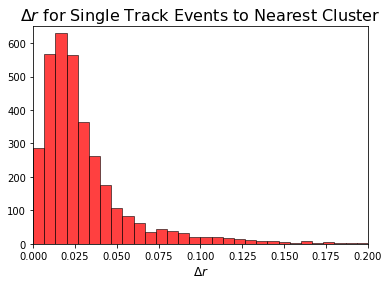

In [18]:
plt.hist(Delta_r_list, bins=30, range=(0,.2), color='red', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('$\Delta r$ for Single Track Events to Nearest Cluster', fontsize=16)
plt.xlim(0,.2)
plt.ylim(0,650)
# plt.xticks(np.arange(0,19))
plt.xlabel('$\Delta r$',fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/DeltaR_singleTrack_nearestCluster_OutputStream_000502_root_2021-05-25.png', format='png')
plt.show()

# Visualization of Barrel Events

In [19]:
# 1) find out how many clusters there are first, then make arrays of these

evt_idx = 119 #pick your favorite event

event_nCells = ak_cluster_nCells["cluster_nCells"][evt_idx]
num_clusters = len(event_nCells)
print('Number of clusters:')
print(num_clusters);print()
print('Total event cell number:')
print(event_nCells);print()

# This is still an awakward array with variable lengths for the cell IDs from clusters
cluster_cell_ID = ak_cluster_cell_ID["cluster_cell_ID"][evt_idx]
print('Cluster Cell IDs: ')
print(cluster_cell_ID);print()

# Initialize a list with all of the cluster cell IDs in a numpy array
# eliminates the use of awkward array .. not sure if this is necessary
cell_ID_list = []
for i in range(num_clusters):
    cell_ID_list.append(cluster_cell_ID[i].to_numpy())
    print('number in cluster ('+str(i)+'): '+str(len(cluster_cell_ID[i])))

Number of clusters:
18

Total event cell number:
[139, 201, 166, 228, 130, 168, 181, 154, 76, 126, 54, 24, 13, 11, 14, 14, 14, 11]

Cluster Cell IDs: 
[[767580074, 767580072, 767580076, 767579562, ... 769661896, 767570890, 1150174720]]

number in cluster (0): 139
number in cluster (1): 105
number in cluster (2): 147
number in cluster (3): 150
number in cluster (4): 96
number in cluster (5): 149
number in cluster (6): 140
number in cluster (7): 78
number in cluster (8): 49
number in cluster (9): 89
number in cluster (10): 48
number in cluster (11): 18
number in cluster (12): 10
number in cluster (13): 6
number in cluster (14): 8
number in cluster (15): 8
number in cluster (16): 9
number in cluster (17): 7


In [20]:
# 2) Find corresponding geometry from cluster IDs
geo_index_list = []

''' loop through the cluster list '''
for i in range(num_clusters):
    
    # figure out the number in the cluster
    num_per_clust = len(cell_ID_list[i])
    
    # creates a temporary array of the indices of each cell ID
    _temp_idx_arr = np.zeros(num_per_clust, dtype=int)
    
    # should return a numpy array with the lists of cell IDs in the cluster
    _temp_ID_arr = cell_ID_list[i]
    
    # loop through the list of cell IDs in a given cluster and find the index in
    # ak_cell_geo_ID (main list)
    for j in range(num_per_clust):
        # extract a single ID from the cluster list
        # zero index necessary due to returns of np.where
        _temp_idx = np.where(cell_geo_ID == _temp_ID_arr[j])[0]
        # need to take the zeroth element of awkward.where to get an array,
        # then take the zeroth element of the array which is the index
        _temp_idx_arr[j] = _temp_idx
    
    # insert the numpy index arrays into a tuple with the length of the cluster
    geo_index_list.append(_temp_idx_arr)

In [21]:
# 3) Make lists to hold numpy arrays
cluster_array_list = []

# 4) use index arrays to find corresponding args for the array

for i in range(num_clusters):
    print('Working on cluster '+str(i))
    num_in_cluster = len(cell_ID_list[i])
    print('Number in cluster: '+str(num_in_cluster));print()
    
    # create a numpy array to be filled in, using number of cell IDs as a length N
    _temp_cluster_arr = np.zeros( (num_in_cluster,7) )
    
    # loop through the number of cells in each cluster
    for j in range(num_in_cluster):
        # pull cell position index from 'j'th array position in 'i'th list position
        _geo_index = geo_index_list[i][j]
        
        _temp_cluster_arr[j,0] = cell_geo_ID[_geo_index]
        _temp_cluster_arr[j,1] = cell_geo_eta[_geo_index]
        _temp_cluster_arr[j,2] = cell_geo_phi[_geo_index]
        _temp_cluster_arr[j,3] = cell_geo_sampling[_geo_index]
        _temp_cluster_arr[j,4] = cell_geo_deta[_geo_index]
        _temp_cluster_arr[j,5] = cell_geo_dphi[_geo_index]
        # each event index will have i clusters and j entries in each cluster
        _temp_cluster_arr[j,6] = ak_cluster_cell_E["cluster_cell_E"][evt_idx][i][j]
    
    # precautionary measure against shallow copy 
    cluster_array_list.append(copy.deepcopy(_temp_cluster_arr)) # necessary for deep copy

if len(cluster_array_list) != 0:
    print(cluster_array_list[0][0,:])
else:
    print(cluster_array_list)

Working on cluster 0
Number in cluster: 139

Working on cluster 1
Number in cluster: 105

Working on cluster 2
Number in cluster: 147

Working on cluster 3
Number in cluster: 150

Working on cluster 4
Number in cluster: 96

Working on cluster 5
Number in cluster: 149

Working on cluster 6
Number in cluster: 140

Working on cluster 7
Number in cluster: 78

Working on cluster 8
Number in cluster: 49

Working on cluster 9
Number in cluster: 89

Working on cluster 10
Number in cluster: 48

Working on cluster 11
Number in cluster: 18

Working on cluster 12
Number in cluster: 10

Working on cluster 13
Number in cluster: 6

Working on cluster 14
Number in cluster: 8

Working on cluster 15
Number in cluster: 8

Working on cluster 16
Number in cluster: 9

Working on cluster 17
Number in cluster: 7

[ 7.67580074e+08  1.08691978e+00 -1.04801881e+00  2.00000000e+00
  2.50000004e-02  2.45436933e-02  1.76954437e+02]


## Convert Clusters into Layers
Use switch from calo sampling layer, EMB1 = 1, EMB2 = 2, EMB3 = 3, TileBar0 = 12, TileBar1 = 13, TileBar2 = 14

In [22]:
# initialize lists to go into arrays lata
EMB1_clust = []
EMB2_clust = []
EMB3_clust = []
TileBar0_clust = []
TileBar1_clust = []
TileBar2_clust = []

# event is populated with a list of arrays which contain the cluster information
for i in range(num_clusters):
    
    for j in range(len(cluster_array_list[i])):
        layer_num = int(cluster_array_list[i][j,3])
        if layer_num == 1:
            EMB1_clust.append(cluster_array_list[i][j,:])
        elif layer_num == 2:
            EMB2_clust.append(cluster_array_list[i][j,:])
        elif layer_num == 3:
            EMB3_clust.append(cluster_array_list[i][j,:])
        elif layer_num == 13:
            TileBar0_clust.append(cluster_array_list[i][j,:])
        elif layer_num == 14:
            TileBar1_clust.append(cluster_array_list[i][j,:])
        elif layer_num == 15:
            TileBar2_clust.append(cluster_array_list[i][j,:])
        else:
            continue

EMB1_clust = concat_array_list(EMB1_clust)
EMB2_clust = concat_array_list(EMB2_clust)
EMB3_clust = concat_array_list(EMB3_clust)
TileBar0_clust = concat_array_list(TileBar0_clust)
TileBar1_clust = concat_array_list(TileBar1_clust)
TileBar2_clust = concat_array_list(TileBar2_clust)

### Find Cluster Center

In [23]:
## TO DO: Add cluster center
num_of_clusters = nCluster[evt_idx]

# Create empty numpy array the length of nclusters by 2 for coordinates
# Use 5 as coordinate centers as this is nonsense for a topocluster so it is a flag 
cluster_centers = np.full((num_of_clusters, 2), 5, dtype=np.float32)

for i in range(num_of_clusters):
    cluster_centers[i,:] = np.array([ak_cluster_Eta["cluster_Eta"][evt_idx][i], ak_cluster_Phi["cluster_Phi"][evt_idx][i]])

print(cluster_centers)

[[ 1.0975002  -1.0469439 ]
 [ 1.0838382  -1.0490068 ]
 [ 1.1340265  -0.9743436 ]
 [ 0.93076605 -0.9564627 ]
 [ 1.1748673  -1.1187581 ]
 [ 1.047462   -1.158123  ]
 [ 1.2249416  -1.0447072 ]
 [ 1.0698297  -1.2287889 ]
 [ 1.1332898  -1.2004637 ]
 [ 1.0829347  -0.8415197 ]
 [ 1.2879274  -1.2418132 ]
 [ 1.3642886  -1.3279927 ]
 [ 1.0377319  -1.3312067 ]
 [ 0.53883785 -0.8496209 ]
 [ 1.3634461  -0.944268  ]
 [ 0.93274415 -1.0308228 ]
 [ 0.98884714 -1.4242069 ]
 [ 0.62689537 -0.654306  ]]


### Display Cluster Center with Cluster in Layer

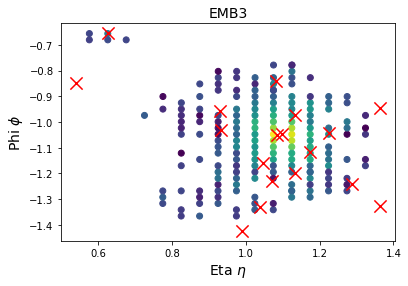

In [24]:
plt.scatter(EMB3_clust[:,1], EMB3_clust[:,2], c=np.log(EMB3_clust[:,6]), cmap=cm.viridis)
for i in range(len(cluster_centers)):
    plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
plt.title('EMB3', fontsize=14)
# plt.xlim(.5,1.4)
# plt.ylim(-1.5,-.6)
plt.xlabel('Eta $\eta$', fontsize=14)
plt.ylabel('Phi $\phi$', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/EMB3_cluster_scatter_colormap_no_track_logscale_2021_05_12.png', format='png')
plt.show()

## Finding Tracking Coordinates

#### Track Coordinates of EMB1 -> TileBar2

In [25]:
# testing
my_coords = track_coords(_idx=evt_idx)
print(my_coords)

[array([[ 1.08743107e+00, -1.04494107e+00],
       [ 1.08743107e+00, -1.04496646e+00],
       [ 1.08743107e+00, -1.04504156e+00],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09]]), array([[ 1.07803845e+00, -1.06274974e+00],
       [ 1.07803953e+00, -1.06256604e+00],
       [ 1.07804561e+00, -1.06148183e+00],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09]]), array([[ 1.09778535e+00, -1.10888004e+00],
       [ 1.09779394e+00, -1.10831702e+00],
       [ 1.09783733e+00, -1.10520148e+00],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09]]), array([[ 1.07722914e+00, -1.02806640e+00],
       [ 1.07722986e+00, -1.02825797e+00],
       [ 1.07723379e+00, -1.02938867e+00],
       [-1.00000000e+09, -1.00000000e+09],
       [-1.00000000e+09, -1.00000000e+09],
    

### Plot clusters and tracks together

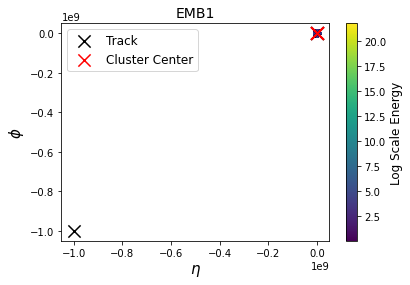

In [26]:
### EMB 1 ###
mynorm = Normalize(vmin=np.min(EMB1_clust[:,6]), vmax=np.max(EMB1_clust[:,6]))
plt.scatter(EMB1_clust[:,1], EMB1_clust[:,2], c=np.log(EMB1_clust[:,6]), cmap=cm.viridis, s=50)
for m in range(len(my_coords)):
    if m == 0:
        plt.scatter(my_coords[m][0,0], my_coords[m][0,1], marker='x', color='black', s=150, label='Track')
    else:
        plt.scatter(my_coords[m][0,0], my_coords[m][0,1], marker='x', color='black', s=150)
for i in range(len(cluster_centers)):
    if i == 0:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150,
                   label='Cluster Center')
    else:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
cb = plt.colorbar(cm.ScalarMappable(norm=mynorm, cmap='viridis'), label='Log Scale Energy', location='right')
cb.set_label(label='Log Scale Energy', size=12)
plt.legend(loc=0, prop={'size':12})
plt.title('EMB1', fontsize=14)
plt.xlabel('$\eta$', fontsize=15)
plt.ylabel('$\phi$', fontsize=15)
# plt.gca().yaxis.set_label_position('right')
# plt.tight_layout()
# plt.savefig('Plots/evt22/EMB1_scatter_wTrack_wClusterCenter_logscale_colormap_2021_05_17.png', format='png')
plt.show()

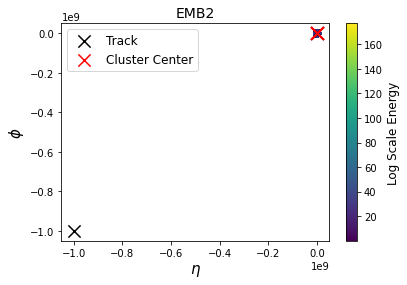

In [27]:
### EMB2 ###
mynorm = Normalize(vmin=np.min(EMB2_clust[:,6]), vmax=np.max(EMB2_clust[:,6]))

plt.scatter(EMB2_clust[:,1], EMB2_clust[:,2], c=np.log(EMB2_clust[:,6]), cmap=cm.viridis, s=50)
for m in range(len(my_coords)):
    if m == 0:
        plt.scatter(my_coords[m][1,0], my_coords[m][1,1], marker='x', color='black', s=150, label='Track')
    else:
        plt.scatter(my_coords[m][1,0], my_coords[m][1,1], marker='x', color='black', s=150)
for i in range(len(cluster_centers)):
    if i == 0:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150,
                   label='Cluster Center')
    else:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
cb = plt.colorbar(cm.ScalarMappable(norm=mynorm, cmap='viridis'), label='Log Scale Energy', location='right')
cb.set_label(label='Log Scale Energy', size=12)
plt.legend(loc=0, prop={'size':12})
plt.title('EMB2', fontsize=14)
plt.xlabel('$\eta$', fontsize=15)
plt.ylabel('$\phi$', fontsize=15)
# plt.tight_layout()
# plt.savefig('Plots/evt22/EMB2_scatter_wTrack_wClusterCenter_logscale_colormap_2021_05_17.png', format='png')
plt.show()

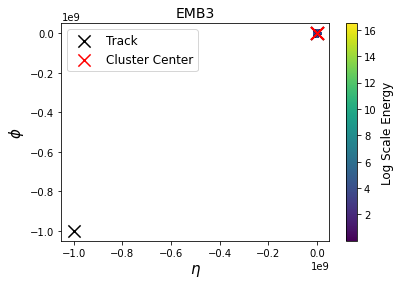

In [28]:
### EMB3 ###
mynorm = Normalize(vmin=np.min(EMB3_clust[:,6]), vmax=np.max(EMB3_clust[:,6]))

plt.scatter(EMB3_clust[:,1], EMB3_clust[:,2], c=np.log(EMB3_clust[:,6]), cmap=cm.viridis, s=50)
for m in range(len(my_coords)):
    if m == 0:
        plt.scatter(my_coords[m][2,0], my_coords[m][2,1], marker='x', color='black', s=150, label='Track')
    else:
        plt.scatter(my_coords[m][2,0], my_coords[m][2,1], marker='x', color='black', s=150)
for i in range(len(cluster_centers)):
    if i == 0:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150,
                   label='Cluster Center')
    else:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
cb = plt.colorbar(cm.ScalarMappable(norm=mynorm, cmap='viridis'), label='Log Scale Energy', location='right')
cb.set_label(label='Log Scale Energy', size=12)
plt.legend(loc=0, prop={'size':12})
plt.title('EMB3', fontsize=14)
plt.xlabel('$\eta$', fontsize=15)
plt.ylabel('$\phi$', fontsize=15)
# plt.xlim(.5,1.4)
# plt.ylim(-1.5,-.6)
# plt.tight_layout()
# plt.savefig('Plots/evt119/EMB3_scatter_wTrack_wClusterCenter_logscale_colormap_2021_05_18.png', format='png')
plt.show()

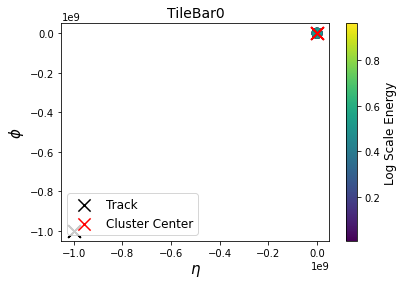

In [29]:
### TileBar0 ###
mynorm = Normalize(vmin=np.min(TileBar0_clust[:,6]), vmax=np.max(TileBar0_clust[:,6]))

plt.scatter(TileBar0_clust[:,1], TileBar0_clust[:,2], c=np.log(TileBar0_clust[:,6]), cmap=cm.viridis, s=100)
for m in range(len(my_coords)):
    if m == 0:
        plt.scatter(my_coords[m][3,0], my_coords[m][3,1], marker='x', color='black', s=150, label='Track')
    else:
        plt.scatter(my_coords[m][3,0], my_coords[m][3,1], marker='x', color='black', s=150)
for i in range(len(cluster_centers)):
    if i == 0:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150,
                   label='Cluster Center')
    else:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
cb = plt.colorbar(cm.ScalarMappable(norm=mynorm, cmap='viridis'), label='Log Scale Energy', location='right')
cb.set_label(label='Log Scale Energy', size=12)
plt.legend(loc=3, prop={'size':12})
plt.title('TileBar0', fontsize=14)
plt.xlabel('$\eta$', fontsize=15)
plt.ylabel('$\phi$', fontsize=15)
# plt.tight_layout()
# plt.savefig('Plots/evt22/TileBar0_scatter_wTrack_wClusterCenter_logscale_colormap_2021_05_17.png', format='png')
plt.show()

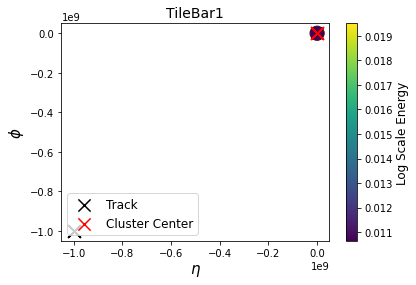

In [30]:
### TileBar1 ###
mynorm = Normalize(vmin=np.min(TileBar1_clust[:,6]), vmax=np.max(TileBar1_clust[:,6]))

plt.scatter(TileBar1_clust[:,1], TileBar1_clust[:,2], c=np.log(TileBar1_clust[:,6]), cmap=cm.viridis, s=200)
for m in range(len(my_coords)):
    if m == 0:
        plt.scatter(my_coords[m][4,0], my_coords[m][4,1], marker='x', color='black', s=150, label='Track')
    else:
        plt.scatter(my_coords[m][4,0], my_coords[m][4,1], marker='x', color='black', s=150)
for i in range(len(cluster_centers)):
    if i == 0:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150,
                   label='Cluster Center')
    else:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
cb = plt.colorbar(cm.ScalarMappable(norm=mynorm, cmap='viridis'), label='Log Scale Energy', location='right')
cb.set_label(label='Log Scale Energy', size=12)
plt.legend(loc=3, prop={'size':12})
plt.title('TileBar1', fontsize=14)
plt.xlabel('$\eta$', fontsize=15)
plt.ylabel('$\phi$', fontsize=15)
# plt.tight_layout()
# plt.savefig('Plots/evt22/TileBar1_scatter_wTrack_wClusterCenter_logscale_colormap_2021_05_17.png', format='png')
plt.show()

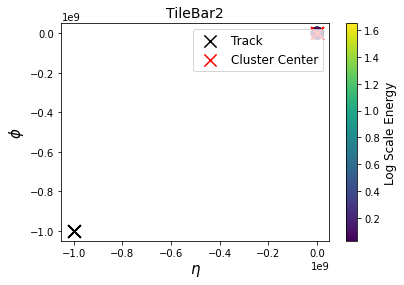

In [31]:
### TileBar2 ###
mynorm = Normalize(vmin=np.min(TileBar2_clust[:,6]), vmax=np.max(TileBar2_clust[:,6]))

plt.scatter(TileBar2_clust[:,1], TileBar2_clust[:,2], c=np.log(TileBar2_clust[:,6]), cmap=cm.viridis, s=150)
for m in range(len(my_coords)):
    if m == 0:
        plt.scatter(my_coords[m][5,0], my_coords[m][5,1], marker='x', color='black', s=150, label='Track')
    else:
        plt.scatter(my_coords[m][5,0], my_coords[m][5,1], marker='x', color='black', s=150)
for i in range(len(cluster_centers)):
    if i == 0:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150,
                   label='Cluster Center')
    else:
        plt.scatter(cluster_centers[i,0], cluster_centers[i,1], color='red', marker='x', s=150)
cb = plt.colorbar(cm.ScalarMappable(norm=mynorm, cmap='viridis'), label='Log Scale Energy', location='right')
cb.set_label(label='Log Scale Energy', size=12)
plt.legend(loc=1, prop={'size':12})
plt.title('TileBar2', fontsize=14)
plt.xlabel('$\eta$', fontsize=15)
plt.ylabel('$\phi$', fontsize=15)
# plt.tight_layout()
# plt.savefig('Plots/evt22/TileBar2_scatter_wTrack_wClusterCenter_logscale_colormap_2021_05_17.png', format='png')
plt.show()

### Now use Imshow

In [32]:
def create_image(layer, _layer_eta, _layer_phi, _layer_E, _logscale=True):
    ''' Takes layer and cluster information to produce a pixel image using binning.
    Inputs: _cl_eta, _cl_phi, _cl_E: ordered np arrays of the same dimension representing
    layer: string of the layer i.e. 'EMB1', 'TileBar0' etc '''
    
    _layer_geo = cell_granularity[layer]
    
    # physical cell dimensions
    _cell_size_eta = _layer_geo['cell_size_eta']
    
    # number of cells
    _nPhi = _layer_geo['nPhi']
    _nEta = _layer_geo['nEta']
    
    _eta_range = _nEta*_cell_size_eta
    _phi_range = 2*np.pi
    
    _eta_min = -(_nEta/2) * _cell_size_eta
    print('eta min: '+str(_eta_min))
    
    # fill with np.nan so hopefully imshow wont plot this?
    _image = np.full((_nEta, _nPhi), np.nan)
    print('image shape '+str(np.shape(_image)))
    
    for i in range(len(_layer_E)):
        
        N = int(np.floor( ( (_layer_eta[i] - _eta_min)/_eta_range) *_nEta ))
        M = int(np.floor( ( (_layer_phi[i] + np.pi)/(2*np.pi)) *_nPhi ))
        
        _inbounds = True
        if N < 0 or M < 0:
            _inbounds = False
        if N >= _nEta or M >= _nPhi:
            _inbounds = False
            
        if _inbounds == True:
            if _logscale:
                _image[N,M] = np.log(_layer_E[i])
            else:
                _image[N,M] = _layer_E[i]
        
    return _image

eta min: -0.7000000000000001
image shape (448, 32)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


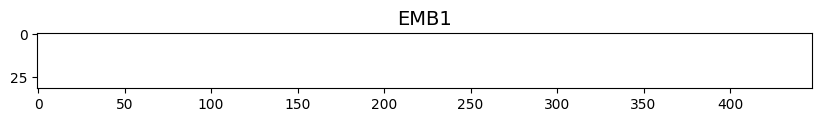

In [33]:
temp_EMB1_image = create_image(layer='EMB1', _layer_eta=EMB1_clust[:,1], _layer_phi=EMB1_clust[:,2],
                               _layer_E=EMB1_clust[:,6], _logscale=True).transpose()
print(temp_EMB1_image)
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(temp_EMB1_image)
current_cmap = plt.cm.get_cmap("viridis").copy()
current_cmap.set_bad(color='white')
plt.title('EMB1',fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/evt22/EMB1_pixel_cluster_2021-05-14.png', format='png')
plt.show()

eta min: -0.7000000000000001
image shape (56, 128)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


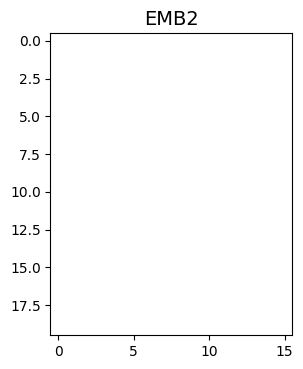

In [34]:
temp_EMB2_image = create_image(layer='EMB2', _layer_eta=EMB2_clust[:,1], _layer_phi=EMB2_clust[:,2],
                               _layer_E=EMB2_clust[:,6], _logscale=True).transpose()
print(temp_EMB2_image)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(temp_EMB2_image[5:25,40:158])
current_cmap = plt.cm.get_cmap("viridis").copy()
current_cmap.set_bad(color='white')
plt.title('EMB2', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/evt22/EMB2_pixel_cluster_2021-05-14.png', format='png')
plt.show()

eta min: -0.7000000000000001
image shape (28, 128)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


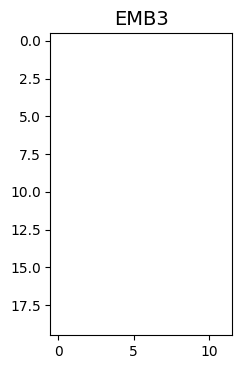

In [35]:
temp_EMB3_image = create_image(layer='EMB3', _layer_eta=EMB3_clust[:,1], _layer_phi=EMB3_clust[:,2],
                               _layer_E=EMB3_clust[:,6], _logscale=True).transpose()
print(temp_EMB3_image)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(temp_EMB3_image[5:25:,16:])
current_cmap = plt.cm.get_cmap("viridis").copy()
current_cmap.set_bad(color='white')
plt.title('EMB3', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/evt22/EMB3_pixel_cluster_2021-05-14.png', format='png')
plt.show()

eta min: -0.7000000000000001
image shape (14, 32)


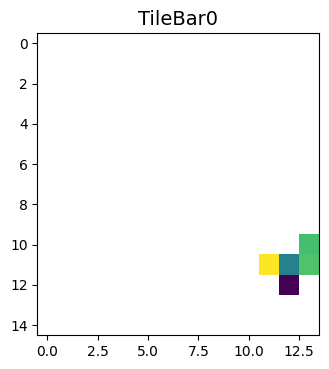

In [36]:
temp_TileBar0_image = create_image(layer='TileBar0', _layer_eta=TileBar0_clust[:,1], _layer_phi=TileBar0_clust[:,2],
                               _layer_E=TileBar0_clust[:,6], _logscale=True).transpose()
# print(temp_TileBar0_image)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(temp_TileBar0_image[0:15,0:15])
current_cmap = plt.cm.get_cmap("viridis").copy()
current_cmap.set_bad(color='white')
plt.title('TileBar0', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/evt22/TileBar0_pixel_cluster_2021-05-14.png', format='png')
plt.show()

eta min: -0.7000000000000001
image shape (14, 32)


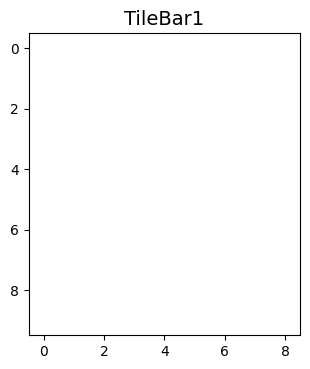

In [37]:
temp_TileBar1_image = create_image(layer='TileBar1', _layer_eta=TileBar1_clust[:,1], _layer_phi=TileBar1_clust[:,2],
                               _layer_E=TileBar1_clust[:,6], _logscale=True).transpose()
# print(temp_TileBar1_image)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(temp_TileBar1_image[0:10,5:15])
current_cmap = plt.cm.get_cmap("viridis").copy()
current_cmap.set_bad(color='white')
plt.title('TileBar1', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/evt22/TileBar1_pixel_cluster_2021-05-14.png', format='png')
plt.show()

eta min: -0.8
image shape (8, 32)


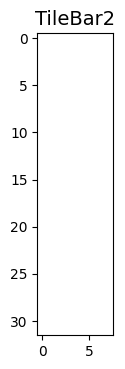

In [38]:
temp_TileBar2_image = create_image(layer='TileBar2', _layer_eta=TileBar2_clust[:,1], _layer_phi=TileBar2_clust[:,2],
                               _layer_E=TileBar2_clust[:,6], _logscale=True).transpose()
# print(temp_TileBar2_image)
plt.figure(figsize=(4,4), dpi=100)
plt.imshow(temp_TileBar2_image)
current_cmap = plt.cm.get_cmap("viridis").copy()
current_cmap.set_bad(color='white')
plt.title('TileBar2', fontsize=14)
# plt.tight_layout()
# plt.savefig('Plots/evt22/TileBar2_pixel_cluster_2021-05-14.png', format='png')
plt.show()

## Six Panel Figure

TypeError: list indices must be integers or slices, not tuple

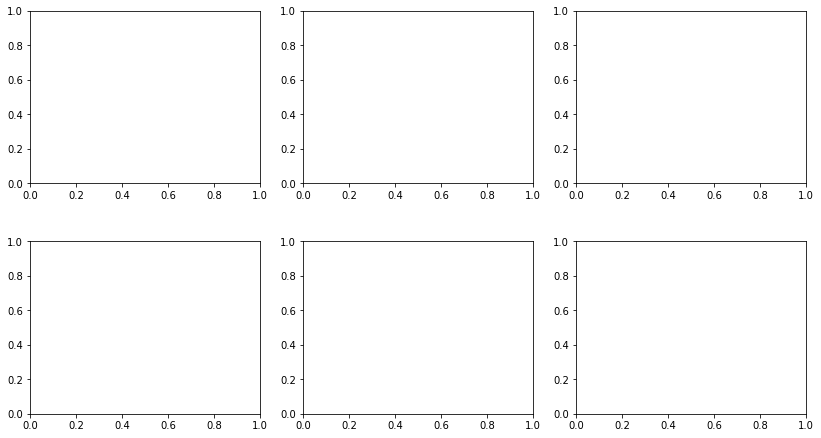

In [39]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_axes([.1,.2,.266,.3])
ax2 = fig.add_axes([.416,.2,.266,.3])
ax3 = fig.add_axes([.732,.2,.266,.3])
ax4 = fig.add_axes([.1,.6,.266,.3])
ax5 = fig.add_axes([.416,.6,.266,.3])
ax6 = fig.add_axes([.732,.6,.266,.3])

ax1.scatter(my_coords[0,0], my_coords[0,1], marker='x', color='black', s=100)
ax1.set_xlim(-1,1)
ax1.set_ylim(-np.pi/2,np.pi/2)

ax2.scatter(my_coords[1,0], my_coords[1,1], marker='x', color='black', s=100)
ax2.set_xlim(-1,1)
ax2.set_ylim(-np.pi/2,np.pi/2)

ax3.scatter(my_coords[2,0], my_coords[2,1], marker='x', color='black', s=100)
ax3.set_xlim(-1,1)
ax3.set_ylim(-np.pi/2,np.pi/2)

ax4.scatter(my_coords[3,0], my_coords[3,1], marker='x', color='black', s=100)
ax4.set_xlim(-1,1)
ax4.set_ylim(-np.pi/2,np.pi/2)

ax5.scatter(my_coords[4,0], my_coords[4,1], marker='x', color='black', s=100)
ax5.set_xlim(-1,1)
ax5.set_ylim(-np.pi/2,np.pi/2)

ax6.scatter(my_coords[5,0], my_coords[5,1], marker='x', color='black', s=100)
ax6.set_xlim(-1,1)
ax6.set_ylim(-np.pi/2,np.pi/2)

plt.show()

# Tracking Histograms

In [ ]:
## Pull all arrays

def empty_to_zero(_rawArr):
    ''' Takes a nested array where some of the arrays are empty and returns
    a 1-D array with zeros where there are empty arrays. '''
    retArr = np.empty(len(_rawArr))
    for i in range(len(_rawArr)):
        if _rawArr[i].size > 0:
            retArr[i] = _rawArr[i][0]
        else:
            retArr[i] = 0
    return retArr

raw_trackPt = event_tree["trackPt"].arrays(library="np")['trackPt']
nTrack = event_tree["nTrack"].arrays(library="np")['nTrack']
raw_trackNumberOfPixelHits = event_tree["trackNumberOfPixelHits"].arrays(library="np")['trackNumberOfPixelHits']
raw_trackNumberOfSCTHits = event_tree["trackNumberOfSCTHits"].arrays(library="np")['trackNumberOfSCTHits']
raw_trackChiSquared = event_tree["trackChiSquared"].arrays(library="np")['trackChiSquared']
raw_trackD0 = event_tree["trackD0"].arrays(library="np")['trackD0']
raw_trackZ0 = event_tree["trackZ0"].arrays(library="np")['trackZ0']

### Layer Histogram

In [ ]:
print(np.shape(cell_geo_sampling))

(187650,)


### Track Z0

In [ ]:
print(raw_trackZ0)
trackZ0 = empty_to_zero(raw_trackZ0)
print(trackZ0)

[array([], dtype=float32) array([8.018657], dtype=float32)
 array([-26.080801], dtype=float32) ... array([-55.30402], dtype=float32)
 array([], dtype=float32) array([-10.402824], dtype=float32)]
[  0.           8.01865673 -26.08080101 ... -55.30401993   0.
 -10.4028244 ]


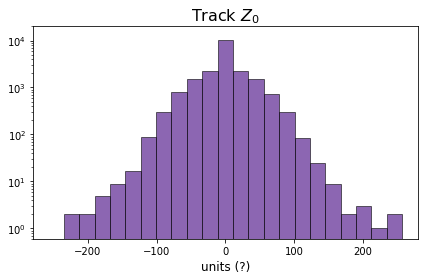

In [ ]:
plt.hist(trackZ0, bins=25, range=(-280,280), color='rebeccapurple', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Track $Z_0$', fontsize=16)
plt.yscale('log')
plt.xlim(-280,280)
plt.ylim(.6,2e4)
# plt.xticks(np.arange(0,19))
plt.xlabel('mm',fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/track_Z0_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### Track D0

In [ ]:
print(raw_trackD0)
trackD0 = empty_to_zero(raw_trackD0)
print(trackD0)

[array([], dtype=float32) array([-0.00386885], dtype=float32)
 array([-0.01672307], dtype=float32) ...
 array([0.19795716], dtype=float32) array([], dtype=float32)
 array([0.00348824], dtype=float32)]
[ 0.         -0.00386885 -0.01672307 ...  0.19795716  0.
  0.00348824]


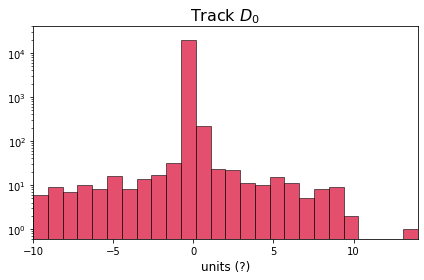

In [ ]:
plt.hist(trackD0, bins=26, range=(-10,14), color='crimson', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Track $D_0$', fontsize=16)
plt.yscale('log')
plt.xlim(-10,14)
plt.ylim(.6,4e4)
# plt.xticks(np.arange(0,19))
plt.xlabel('mm',fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/track_D0_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### Chi Squared of track fit

In [ ]:
print(raw_trackChiSquared)
trackChiSquared = empty_to_zero(raw_trackChiSquared)
print(trackChiSquared)

[array([], dtype=float32) array([49.02249], dtype=float32)
 array([24.274464], dtype=float32) ... array([28.709236], dtype=float32)
 array([], dtype=float32) array([37.139793], dtype=float32)]
[ 0.         49.02249146 24.27446365 ... 28.70923615  0.
 37.1397934 ]


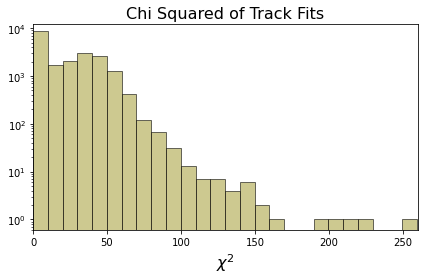

In [ ]:
plt.hist(trackChiSquared, bins=26, color='darkkhaki', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Chi Squared of Track Fits', fontsize=16)
plt.yscale('log')
plt.xlim(0,260)
plt.ylim(.6,1.2e4)
# plt.xticks(np.arange(0,19))
plt.xlabel('$\chi^2$',fontsize=16)
# plt.tight_layout()
# plt.savefig('Plots/track_Chisq_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### SCT Hits

In [ ]:
print(raw_trackNumberOfSCTHits)
trackNumberOfSCTHits = empty_to_zero(raw_trackNumberOfSCTHits).astype(np.int32)
print(trackNumberOfSCTHits[0:20])

[array([], dtype=int32) array([12], dtype=int32) array([9], dtype=int32)
 ... array([8], dtype=int32) array([], dtype=int32)
 array([8], dtype=int32)]
[ 0 12  9 10  7  9  8  8  8 10  0  8  0  8  8  9  8  0  0  8]


[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5 17.5 18.5]


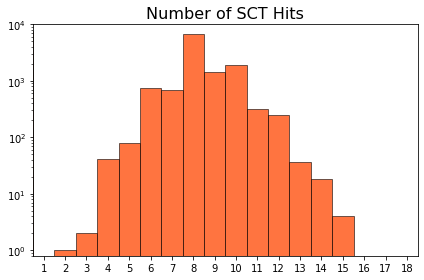

In [ ]:
bin_list = np.linspace(-.5, 18.5, num=20, endpoint=True)
print(bin_list)

plt.hist(trackNumberOfSCTHits, bins=bin_list, color='orangered', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Number of SCT Hits', fontsize=16)
plt.yscale('log')
plt.xlim(.5,18.5)
plt.ylim(.8,1e4)
plt.xticks(np.arange(1,19))
# plt.tight_layout()
# plt.savefig('Plots/SCTHits_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### Pixel Hits

In [ ]:
print(raw_trackNumberOfPixelHits)
trackNumberOfPixelHits=empty_to_zero(raw_trackNumberOfPixelHits).astype(np.int32)
print(track_NumberOfPixelHits[0:20])

[array([], dtype=int32) array([5], dtype=int32) array([5], dtype=int32)
 ... array([4], dtype=int32) array([], dtype=int32)
 array([4], dtype=int32)]
[0 5 5 4 3 6 4 4 5 4 0 3 0 4 4 4 3 0 0 3]


[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5]


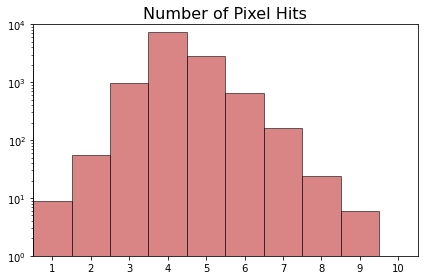

In [ ]:
bin_list = np.linspace(-.5, 10.5, num=12, endpoint=True)
print(bin_list)

plt.hist(trackNumberOfPixelHits, bins=bin_list, color='indianred', alpha=.75, linewidth=.75, edgecolor='black')
plt.title('Number of Pixel Hits', fontsize=16)
plt.yscale('log')
plt.xlim(.5,10.5)
plt.ylim(1,1e4)
plt.xticks(np.arange(1,11))
# plt.tight_layout()
# plt.savefig('Plots/PixelHits_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### Track number

In [ ]:
print(nTrack)

[0 1 1 ... 1 0 1]


[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5]


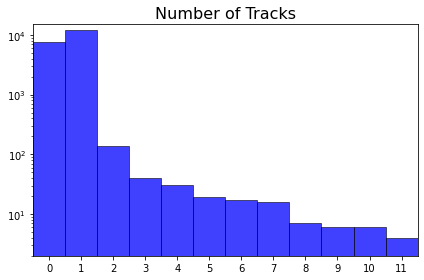

In [ ]:
bin_list = np.linspace(-.5, 11.5, num=13, endpoint=True)
print(bin_list)

plt.hist(nTrack, bins=bin_list, alpha=.75, color='blue', linewidth=.75, edgecolor='black')
plt.title('Number of Tracks', fontsize=16)
plt.yscale('log')
plt.xlim(-.5,11.5)
plt.ylim(2,1.5e4)
plt.xticks(np.arange(0,12))
# plt.tight_layout()
# plt.savefig('Plots/nTracks_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### Track Pt

In [ ]:
trackPt = empty_to_zero(raw_trackPt)
print('Length of trackPt: '+str(len(raw_trackPt)))
print('Maximum trackPt: '+str(np.max(trackPt)))
print(trackPt)

Length of trackPt: 20000
Maximum trackPt: 2161563.0
[  0.         529.78540039   8.8500309  ...   0.78071713   0.
  95.6516571 ]


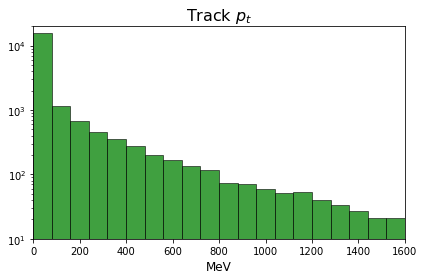

In [ ]:
plt.hist(trackPt, bins=20, range=(0,1600), alpha=.75, color='green', edgecolor='black', linewidth=.75)
plt.yscale('log')
plt.ylim(10,20000)
plt.xlim(0,1600)
plt.title('Track $p_t$',fontsize=16)
plt.xlabel('MeV',fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/trackPt_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()

### Cluster information
#### use index list in barrel events

In [ ]:
# create list of all of the phi values of events which are in the barrel
barrel_cell_phi = []

t1 = t.time()

for _evt_idx in barrel_events:

    # pull nested array of cluster cell IDs
    cluster_cell_ID = ak_cluster_cell_ID["cluster_cell_ID"][_evt_idx]

    for j in range(len(cluster_cell_ID)):
        ''' loop through each cluster of the event '''

        for l in range(len(cluster_cell_ID[j])):
            ''' loop through the cluster elements searching for new layer numbers'''
            # grab the first cell_geo_ID
            _cell_geo_tag = cluster_cell_ID[j][l]
        
            # find the index of the cell_geo_ID, use [0][0] becuase of np.where return
            _cell_geo_idx = np.where(cell_geo_ID == _cell_geo_tag)[0][0]

            # find the sampling layer based on the index
            this_layer = cell_geo_sampling[_cell_geo_idx]

            # check if the cell sampling is in the barrel
            if np.isin(this_layer, calo_layer_filter):
                barrel_cell_phi.append( cell_geo_phi[_cell_geo_idx] )

t2 = t.time()
print('Time to loop through all clusters: '+str(t2-t1))

Time to loop through all clusters: 273.14963006973267


In [ ]:
print(barrel_cell_phi[0:25])

[-2.9282923, -2.952828, -2.9282923, -2.952828, 1.8811033, 1.8565255, 1.9056808, 1.8811022, 1.881104, 1.8565261, 1.9056797, 1.9056815, 1.918034, 1.918034, 1.918034, 1.918034, 1.918034, 1.8810563, 1.881104, 1.8565261, 1.918034, 1.8197051, 1.8197051, 1.8197051, 1.8197051]


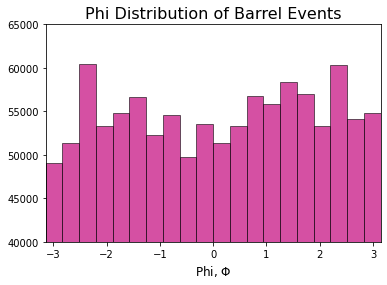

In [ ]:
barrel_cell_phi = np.array(barrel_cell_phi)

plt.hist(barrel_cell_phi, bins=20, range=(-np.pi, np.pi), alpha=.75, color='mediumvioletred',
         edgecolor='black', linewidth=.75)
# plt.yscale('log')
plt.ylim(40000,65000)
plt.xlim(-np.pi,np.pi)
plt.title('Phi Distribution of Barrel Events',fontsize=16)
plt.xlabel('Phi, $\Phi$',fontsize=12)
# plt.tight_layout()
# plt.savefig('Plots/trackPt_OutputStream_000502_root_2021-05-10.png', format='png')
plt.show()